**IMPORTING LIBRARIES** 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import datetime
import time


import tensorflow as tf
import keras
from tensorflow.keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from tensorflow.keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

**MOUNTING THE DRIVE**

In [2]:

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/cs2")

This model is an encoder decoder model where encoder extracts the features and decoder generate reports

**Loading cheXNet Model**

In [4]:
#The trained weights of this model is from https://github.com/brucechou1983/CheXNet-Keras
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py

from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet=Model(inputs=base.input,outputs=pred)
chexnet.load_weights("chexnet_weights.h5")#downloaded weights

chexnet.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [5]:
final_chexnet_model=Model(inputs=chexnet.inputs,outputs=chexnet.layers[-2].output,name="Chexnet")

In [ ]:
tf.keras.utils.plot_model(final_chexnet_model,show_shapes=True,show_layer_names=True,to_file="chexnet_model.png")

Here we loaded the pre trained model and removed last two layers and take the output from it as the features for our model

**GETTING FEATURES FROM CHEXNET MODEL**

In [7]:
img_1= Input(shape=(224,224,3),name="image_1_features")
img_2= Input(shape=(224,224,3),name="image_2_features")
img_1_out=final_chexnet_model(img_1)
img_2_out=final_chexnet_model(img_2)
conc=concatenate((img_1_out,img_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[img_1,img_2],outputs=conc)
feature_extraction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_2_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Chexnet (Functional)            (None, 1024)         7037504     image_1_features[0][0]           
                                                                 image_2_features[0][0]           
__________________________________________________________________________________________________
final_image_features (Concatena (None, 2048)         0           Chexnet[0][0]              

We have two images for every patient in our data so we give these as inputs to the chexnet model and we concatenate the outputs and we use it as final features for the patient

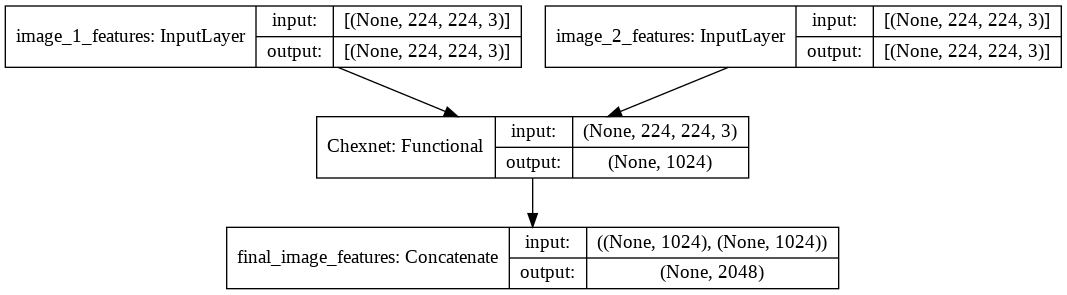

In [8]:
tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True)

Now we need to prepare the data for encoder-decoder model. The inputs to the encoder model is:

The image feature corresponding to the x-rays of every patient
The encoder model will do have some layers that transform this 2048 dimensional image features into a lower dimensional tensor

The inputs to the decoder are:

The image feature vector output from the encoder model

The text embeddings we got from the Findings

**LOADING DATA**

In [9]:
Train=pd.read_csv("Train_Data.csv")
CV = pd.read_csv('CV_Data.csv')
Test = pd.read_csv("Test_Data.csv")

print(Train.shape)
print(CV.shape)
print(Test.shape)

(2758, 4)
(550, 4)
(399, 4)


In [10]:
Train.head()

,Person_id,Image-1,Image-2,Findings
0,x ray data/CXR1_1_IM-0001_0,x ray data/CXR1_1_IM-0001-3001.png,x ray data/CXR1_1_IM-0001-4001.png,SOS the cardiac silhouette and mediastinum siz...
1,x ray data/CXR10_IM-0002_0,x ray data/CXR10_IM-0002-1001.png,x ray data/CXR10_IM-0002-2001.png,SOS the cardiomediastinal silhouette within no...
2,x ray data/CXR100_IM-0002_0,x ray data/CXR100_IM-0002-1001.png,x ray data/CXR100_IM-0002-2001.png,SOS both lungs are clear and epanded . heart ...
3,x ray data/CXR1000_IM-0003_0,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-2001.png,SOS there increased opacity within the right u...
4,x ray data/CXR1000_IM-0003_1,x ray data/CXR1000_IM-0003-1001.png,x ray data/CXR1000_IM-0003-3001.png,SOS there increased opacity within the right u...


In [11]:
t_x=Train['Image-1'].unique()
c_x=CV['Image-1'].unique()
te_x=Test['Image-1'].unique()


In [12]:
t_xs = set (t_x)
c_xs = set (c_x)
te_xs = set (te_x)

print(len(t_xs & c_xs))
print(len(t_xs & te_xs))
print(len(c_xs&te_xs))

0
0
0


Here we can see that there are no same images in train,cv and Image Data

In [13]:
#The output from this function is 2048 dimensional vector for the x-ray set of every patient

def image_feature_extraction(image1,image2):
   
    image_1 = Image.open(image1)
    image_1= np.asarray(image_1.convert("RGB"))

    image_2=Image.open(image2)
    image_2 = np.asarray(image_2.convert("RGB"))

    #normalizing the values of the image
    image_1=image_1/255
    image_2=image_2/255

    #resizing all image into (224,224)
    image_1 = cv2.resize(image_1,(224,224))
    image_2 = cv2.resize(image_2,(224,224))

    image_1= np.expand_dims(image_1, axis=0)
    image_2= np.expand_dims(image_2, axis=0)

    #Feeding to the chexnet model for image feature extraction

    image_feature=feature_extraction_model([image_1,image_2])

    return image_feature


In [ ]:
'''train_features=[]
for row in tqdm(range(Train.shape[0])):
    image_1=Train.iloc[row]["Image-1"]
    image_2=Train.iloc[row]["Image-2"]
    train_features.append(image_feature_extraction(image_1,image_2))
print("DONE")'''

In [ ]:
'''test_features=[]
for row in tqdm(range(Test.shape[0])):
    image_1=Test.iloc[row]["Image-1"]
    image_2=Test.iloc[row]["Image-2"]
    test_features.append(image_feature_extraction(image_1,image_2))
print("DONE")'''

In [ ]:
'''cv_features=[ ]
for row in tqdm(range(cv.shape[0])):
    image_1=cv.iloc[row]["Image-1"]
    image_2=cv.iloc[row]["Image-2"]
    cv_features.append(image_feature_extraction(image_1,image_2))
print("DONE")'''

In [ ]:
'''np.save("train_image_features",train_features)
np.save("test_image_features",test_features)
np.save('cv_image_features',cv_features)'''

We got the image features from the chexnet model and saved in the drive 

**LOADING THE EXTRACTED IMAGE FEATURES**

In [14]:
train_features=np.load("train_image_features.npy")
test_features=np.load("test_image_features.npy")
cv_features = np.load("cv_image_features.npy")

In [15]:
print(train_features.shape)

(2758, 1, 2048)


In [17]:
#processing the text feature for embedding
train_report=[text for text in Train["Findings"].values]
test_report=[text for text in Test['Findings'].values]
cv_report = [text for text in CV['Findings'].values]

In [18]:
print(len(train_report))
print(len(cv_report))
print(len(test_report))

2758
550
399


In [19]:
#finding number of words in each report
words = [len(i.split()) for i in Train['Findings'].values] 
print(max(words))

155


In [20]:
train_report[0]

'SOS the cardiac silhouette and mediastinum size are within normal limits .  there no pulmonary edema .  there no focal consolidation .  there are no pleural effusion .  there no evidence pneumothora .  EOS'

In [21]:
# Converting words to tokens using tensorflow tokenizer

token=tf.keras.preprocessing.text.Tokenizer(filters='' )
token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1

In [22]:
#using fast embedding
embeddings_index=dict()
f = open('crawl-300d-2M.vec',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 1426/1426 [00:00<00:00, 204642.20it/s]

Done


In [ ]:
#Using glove for getting 300 dimension vector for every token
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
'''embeddings_index=dict()
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector'''

100%|██████████| 1426/1426 [00:00<00:00, 218494.83it/s]

Done


In [23]:
print(token.word_index)

{'.': 1, 'the': 2, 'no': 3, 'are': 4, 'normal': 5, 'sos': 6, 'eos': 7, 'and': 8, 'pleural': 9, 'there': 10, 'pneumothora': 11, 'effusion': 12, 'heart': 13, 'lungs': 14, 'size': 15, 'focal': 16, 'within': 17, 'clear': 18, 'limits': 19, 'pulmonary': 20, 'consolidation': 21, 'silhouette': 22, 'right': 23, 'mediastinal': 24, 'airspace': 25, 'cardiomediastinal': 26, 'left': 27, 'acute': 28, 'lung': 29, 'with': 30, 'unremarkable': 31, 'disease': 32, 'stable': 33, 'spine': 34, 'mediastinum': 35, 'structures': 36, 'changes': 37, 'contours': 38, 'thoracic': 39, 'bony': 40, 'contour': 41, 'mild': 42, 'degenerative': 43, 'large': 44, 'seen': 45, 'appear': 46, 'opacity': 47, 'osseous': 48, 'without': 49, 'calcified': 50, 'cardiac': 51, 'effusions': 52, 'vascularity': 53, 'intact': 54, 'abnormality': 55, 'for': 56, 'visualized': 57, 'evidence': 58, 'opacities': 59, 'upper': 60, 'lateral': 61, 'vasculature': 62, 'chest': 63, 'lobe': 64, 'aorta': 65, 'noted': 66, 'identified': 67, 'volumes': 68, 'bil

In [24]:
t_w = []
for keys in token.word_index:
  t_w.append(keys)

print(len(t_w)) 

1426


In [25]:
#checking how many words are there in the embedding file
x = []
for keys in embeddings_index:
  x.append(keys)
print(len(x))

2000000


In [27]:
#checking how many common words are present in our vocab and embedding file
t_ws = set (t_w)
x_s  = set (x)
com = (x_s & t_ws)
print('{0} % of train words present in embedding file'.format(len(com)/len(t_ws)*100))

88.35904628330997 % of train words present in embedding file


In [28]:
max_len=155 #As we got in eda 

**ENCODER DECODER MODEL**

In [30]:
#constructing the encoder-decoder model

#encoder model
img_input=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="encoder_dense")(img_input)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_dec= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=26),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM-1")(embedding_out)

lstm_dec= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=26),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM-2")(lstm_dec) 

x=Dropout(0.5)(lstm_dec)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed =1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[img_input,input_text],outputs=x1)
encoder_decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 155)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 155, 300)     428100      text[0][0]                       
__________________________________________________________________________________________________
LSTM-1 (LSTM)                   (None, 155, 256)     570368      embedding_1[0][0]                
__________________________________________________________________________________________________
Images (InputLayer)             [(None, 2048)]       0                                            
____________________________________________________________________________________________

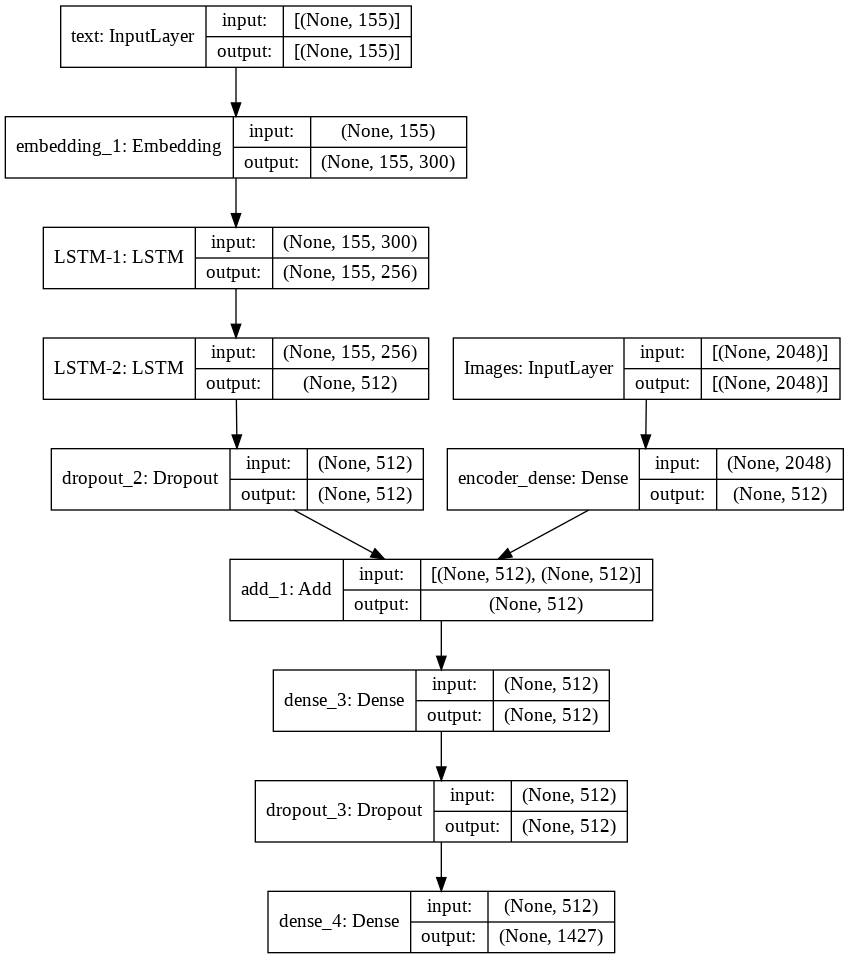

In [31]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True,show_layer_names=True,to_file="Enc_Dec.png")

In [32]:
#random size
batch_size=20

In [33]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_report))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

cv_dataset = tf.data.Dataset.from_tensor_slices((cv_features,cv_report))
cv_dataset = cv_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [34]:
#printing the point of train dataset
for element,report in train_dataset:
    pass
print(element[0],report[0])

tf.Tensor(
[[1.6364084e-04 2.1801861e-03 2.3592296e-03 ... 8.1492442e-01
  8.3395708e-01 6.6792256e-01]], shape=(1, 2048), dtype=float32) tf.Tensor(b'SOS heart and mediastinum are within normal limits .  no focal consolidation .  no large pleural effusion pneumothora .  no acute bony abnormality .  EOS', shape=(), dtype=string)


In [35]:
#here we prepare the data for training
def prep_data(images,Findings):
    imgs = []
    input_reports = []
    output_reports = []
    for i in range(len(images)):
        seq=[] 
        for ele in Findings[i].split(" "):
            if ele in token.word_index.keys():
                seq.append(token.word_index[ele])
        for j in range(1,len(seq)):

            in_seq = seq[:j]
            out_seq = seq[j]
            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            input_reports.append(in_seq)
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)

In [36]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [37]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [38]:
train_loss_list = []
cv_loss_list=[]

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_train = 0
    batch_loss_cv = 0
    
    for img, report in train_dataset:
        
        rep = [word.decode('utf-8') for word in np.array(report)] # convert the tensor to array and then decode it 

        #for each set of elements in dataset prepare the data using load_data function
        img_input, rep_input, output_word = prep_data(img.numpy(), rep)
        #padd the input so as to feed into the model
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=155, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(train_report)//20)

    
    
    for img, report in cv_dataset:
        
        rep = [word.decode('utf-8') for word in np.array(report)]
        img_input, rep_input, output_word = prep_data(img.numpy(), rep)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=155, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        loss = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_cv += loss
    
    cv_loss = batch_loss_cv/(len(cv_report)//20)
    

    train_loss_list.append(train_loss)

    cv_loss_list.append(cv_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, cv_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
Training Loss: 0.0033616349848843837,  Val Loss: 0.0031466525461938647
Time Taken for this Epoch : 50.333149909973145 sec
EPOCH :  2
Training Loss: 0.002798363547704189,  Val Loss: 0.0024819710136701665
Time Taken for this Epoch : 24.770296573638916 sec
EPOCH :  3
Training Loss: 0.0021950589130924894,  Val Loss: 0.001975748640554095
Time Taken for this Epoch : 24.620223999023438 sec
EPOCH :  4
Training Loss: 0.0018309871334732124,  Val Loss: 0.0017307126265088165
Time Taken for this Epoch : 24.67144513130188 sec
EPOCH :  5
Training Loss: 0.0016066590353785368,  Val Loss: 0.0015605621910826475
Time Taken for this Epoch : 24.698105812072754 sec
EPOCH :  6
Training Loss: 0.0014587683657551335,  Val Loss: 0.0014500112436642801
Time Taken for this Epoch : 24.59642791748047 sec
EPOCH :  7
Training Loss: 0.0013430887377773324,  Val Loss: 0.001382621764032929
Time Taken for this Epoch : 24.71844172477722 sec
EPOCH :  8
Training Loss: 0.0012571806518061862,  Val Loss: 0.0013427936269

In [39]:
encoder_decoder.load_weights('encoder_decoder_epoch_20.h5')

**Evaluating the Model on some Random Data**

In [40]:
def evaluate(img_1,img_2):
    #Given the images from test data, we extract the bottleneck features from chexnet model
    image_features = image_feature_extraction(img_1,img_2)
    output_report=""
    
    #first word for the report is given as sos
    inp= "sos"

    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    for i in range(max_len):
        #we find the list of tokens for the input word (already available words)
        list_of_tokens = [token.word_index[w] for w in inp.split()]

        #padd the available tokens to max_len
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([list_of_tokens],max_len, padding='post')
        
        #we pass the image_features and the padded input to the enocoder decoder model and predict the next token
        predictions = encoder_decoder.predict([image_features,input_padded])
        
        #find the corresponding word and attach to the result
        arg = np.argmax(predictions[0]) 
        
        if token.index_word[arg]=="eos":
          
          output_report+=token.index_word[arg]+" "
          break
        else:
            
            output_report+=token.index_word[arg]+" "
            inp+= ' ' + token.index_word[arg]
        
    
    return output_report

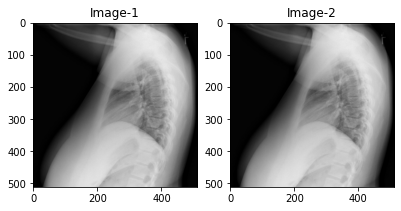

ACTUAL REPORT:  SOS images .  heart size and pulmonary vascular engorgement appear within limits normal .  mediastinal contour unremarkable .  no focal consolidation pleural effusion pneumothora identified .  no convincing acute bony findings .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . degenerative changes the thoracic spine . there are no displaced rib fractures . there are no acute bony abnormality . there no free intraperitoneal air under the diaphragm . there mild degenerative changes the spine . there are mild degenerative changes the spine . there are postsurgical clips the right upper quadrant . there no suprapatellar . there no large pleural effusion . there no pneumothora . there are degenerative changes the spine . there are postsurgical changes the right upper quadrant . there are postoperative changes the cervical spine . there are postsurgical clips

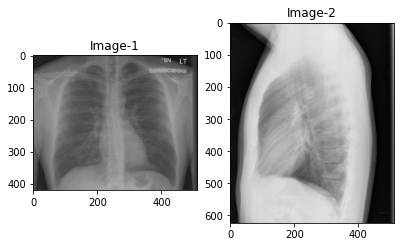

ACTUAL REPORT:  SOS surgical the distal left clavicle .  no acute osseous abnormality .  soft tissue structures are within normal limits .  stable normal cardio mediastinal silhouettes and hilar structures .  the lungs are normally inflated without evidence focal airspace disease pleural effusion pneumothora .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . there are degenerative changes the thoracic spine . there are postsurgical changes the spine . there are postsurgical changes the right upper quadrant . the abdomen unremarkable . there no evidence pleural effusion pneumothora . the visualized bony structures reveal no acute abnormalities . lateral view reveals mild degenerative changes the thoracic spine . no focal area consolidation pleural effusion pneumothora . the visualized osseous structures and upper abdomen are unremarkable . there evidence for fracture . 

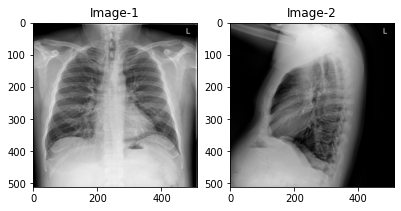

ACTUAL REPORT:  SOS the heart size and pulmonary vascularity appear within normal limits .  the lungs are free focal airspace disease .  no pleural effusion pneumothora seen .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . there are degenerative changes the thoracic spine . there are postsurgical clips the right upper quadrant . the abdomen unremarkable . there no evidence free intraperitoneal air under the diaphragm . there no evidence free intraperitoneal air under the diaphragm . the bony structures appear intact . there are mild degenerative changes the spine . there are postsurgical changes . there are degenerative changes the midthoracic . there are postsurgical changes . there are postsurgical changes . the right chest with tip cavoatrial junction . there no pneumothora . the visualized bony structures reveal no acute abnormalities . there no pneumothora pneum

In [ ]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img_1=Test.iloc[i]["Image-1"]
  img_2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img_1)
  i2=cv2.imread(img_2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("Image-1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("Image-2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img_1,img_2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

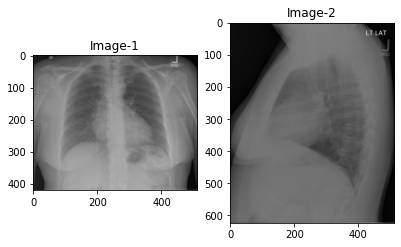

ACTUAL REPORT:  SOS lungs are clear without focal consolidation effusion pneumothora .  normal heart size .  negative for pneumoperitoneum .  mild degenerative changes the thoracic spine .  EOS
GENERATED REPORT:  silhouettes are within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . no acute bony abnormality . soft tissues grossly unremarkable . no evidence pneumothora rib fractures . degenerative changes the thoracic spine are noted . there neurostimulator deformity the vertebral body . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are vascular calcifications . there mild anterior wedge fusion vertebral body . this ageindeterminate . there are degenerative changes the spine . there are vascular calcifications anterior we

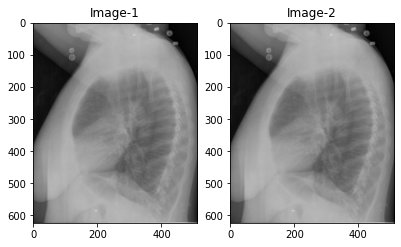

ACTUAL REPORT:  SOS there mild blunting the costophrenic there right basilar airspace disease .  there no pneumothora .  the cardiac mediastinal silhouettes are normal .  pulmonary are slightly prominent .  calcified hilar lymph no acute bony abnormalities .  EOS
GENERATED REPORT:  silhouettes are within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . no acute bony abnormality . soft tissues grossly unremarkable . no evidence pneumothora rib fractures . degenerative changes the thoracic spine are noted . there neurostimulator deformity the vertebral body . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are vascular calcifications . there mild anterior wedge fusion vertebral body . this ageindeterminate . there are degenera

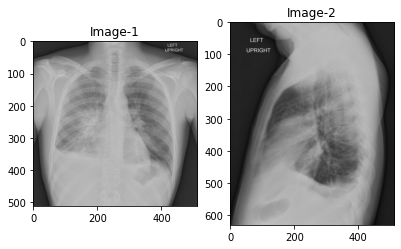

ACTUAL REPORT:  SOS picc line catheter tip the right atrium .  heart not enlarged .  trachea and bronchi appear normal .  lungs are mildly under epanded .  no pneumothora .  there are small areas patchy density the left lower lung there larger area patchy density the right mid and lower lungs with rightsided pleural effusion .  EOS
GENERATED REPORT:  silhouettes are within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . no acute bony abnormality . soft tissues grossly unremarkable . no evidence pneumothora rib fractures . degenerative changes the thoracic spine are noted . there neurostimulator deformity the vertebral body . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are vascular calcifications . there mild anterior we

In [ ]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img_1=Test.iloc[i]["Image-1"]
  img_2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img_1)
  i2=cv2.imread(img_2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("Image-1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("Image-2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img_1,img_2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

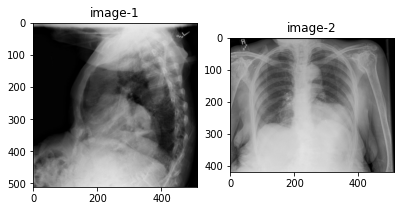

ACTUAL REPORT:  SOS the lungs and pleural spaces show no acute abnormality .  heart size enlarged pulmonary vascularity within normal limits .  marked tortuosity the thoracic aorta .  there are advanced degenerative changes the glenohumeral joints bilaterally with boneonbone articulation remodeling the glenoid and etensive subchondral cystic change .  no displaced rib fractures are visualized .  diffuse osteopenia the thoracic spine with mid thoracic and several lower thoracic deformities ageindeterminate .  there airfluid level the middle mediastinum most secondary large hiatal hernia .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . degenerative changes the thoracic spine . there are mild degenerative changes the spine . there are postsurgical changes the thoracic spine . there are postsurgical changes the right upper quadrant . there ivc the right hemidiaphragm and

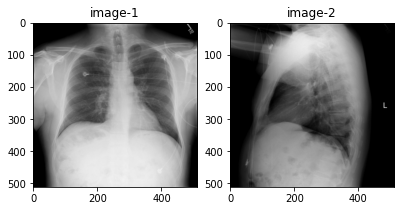

ACTUAL REPORT:  SOS the heart normal size and contour .  the lungs are clear without evidence infiltrate .  there no pneumothora effusion .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . there are degenerative changes the thoracic spine . there are postsurgical clips the right upper quadrant . the abdomen unremarkable . there no evidence free intraperitoneal effusion . the visualized bony structures reveal no acute abnormalities . lateral view reveals mild degenerative changes the thoracic spine . no evidence focal pulmonary opacity . there no pneumothora . there no evidence large pleural effusion . the visualized bony structures reveal no acute abnormalities . heart size and pulmonary vascularity within normal limits . are unremarkable appearance the right upper lobe unchanged . the lungs are clear . there are no focal air space consolidations . no pleural effusions

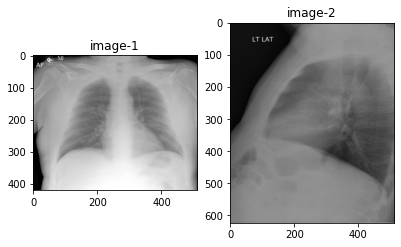

ACTUAL REPORT:  SOS three images submitted .  cardiomediastinal silhouette and pulmonary vasculature are within normal limits .  lungs are clear .  no pneumothora pleural effusion .  no acute osseous findings .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . there are degenerative changes the thoracic spine . there are postsurgical clips the right upper quadrant . the visualized bony structures reveal no acute abnormalities . lateral view reveals mild degenerative changes the thoracic spine . no acute bony abnormality . no effusion pneumothora . no pneumothora pneumomediastinum . no focal lung consolidation . no pleural effusion pneumothora . heart size and pulmonary vascularity within normal limits . are intact . no acute bony abnormality . there are mild degenerative changes the thoracic spine . there are postsurgical clips the right upper quadrant . the abdomen unr

In [ ]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img_1=Test.iloc[i]["Image-1"]
  img_2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image-1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image-2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img_1,img_2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

In [41]:
index=range(0,Train.shape[0])
res=[]
start=time.time()
for i in (index):
  img_1=Train.iloc[i]["Image-1"]
  img_2=Train.iloc[i]["Image-2"]
  result=evaluate(img_1,img_2) 
  actual=train_report[i]
  res.append(bleu.sentence_bleu(actual,result))
end=time.time() 
#print("average bleu score on the test data is ",res/Train.shape[0])
print("time taken for evaluation is ",end-start)

time taken for evaluation is  19786.193571567535


In [42]:
print(len(res))

2758


In [70]:
max(res)

0.408248290463863

In [45]:
from pickle import dump
dump(res,open('train_res.pkl','wb'))

In [43]:
index=range(0,CV.shape[0])
cv_res=[]
start=time.time()
for i in (index):
  img_1=CV.iloc[i]["Image-1"]
  img_2=CV.iloc[i]["Image-2"]
  result=evaluate(img_1,img_2) 
  actual=cv_report[i]
  cv_res.append(bleu.sentence_bleu(actual,result))
end=time.time() 
#print("average bleu score on the test data is ",res/Train.shape[0])
print("time taken for evaluation is ",end-start)

time taken for evaluation is  3905.152848958969


In [44]:
len(cv_res)

550

In [46]:
from pickle import dump
dump(cv_res,open('validation_res.pkl','wb'))

In [49]:
max(cv_res)

0.40340567512868464

**Box Plot on Bleu scores of Train and Validation data**

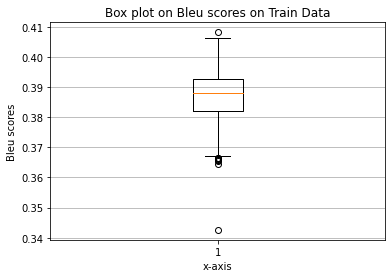

In [69]:
fig, ax = plt.subplots()

data = res
# build a box plot
ax.boxplot(data)


# title and axis labels
ax.set_title('Box plot on Bleu scores on Train Data')
ax.set_xlabel('x-axis')
ax.set_ylabel('Bleu scores')
ax.yaxis.grid(True)


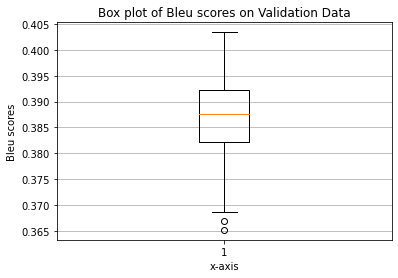

In [66]:
fig, ax = plt.subplots()

data = cv_res
# build a box plot
ax.boxplot(data)


# title and axis labels
ax.set_title('Box plot of Bleu scores on Validation Data')
ax.set_xlabel('x-axis')
ax.set_ylabel('Bleu scores')
ax.yaxis.grid(True)


**Dist plot on Train And Validation Data Bleu scores**

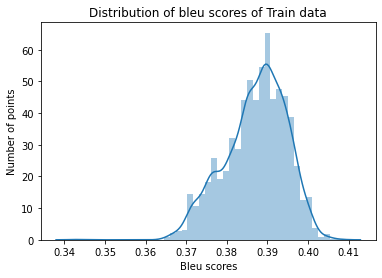

In [58]:
pd.set_option('display.max_colwidth', -1)
sns.distplot(res)


plt.xlabel('Bleu scores')
plt.ylabel('Number of points')
plt.title('Distribution of bleu scores of Train data')
plt.plot()
plt.savefig('bleu_train_gram.png', dpi=600)

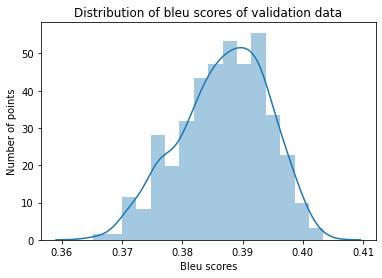

In [59]:
pd.set_option('display.max_colwidth', -1)
sns.distplot(cv_res)


plt.xlabel('Bleu scores')
plt.ylabel('Number of points')
plt.title('Distribution of bleu scores of validation data')
plt.plot()
plt.savefig('bleu_validation.png', dpi=600)

From the above plots we can see that bleu scores on training and validation data lied in the range of 0.35 to 0.41 and median lied around 0.39 in both train and validation data 

**Checking on Test Data**

In [ ]:
index=range(0,Test.shape[0])
res=0
start=time.time()
for i in (index):
  img_1=Test.iloc[i]["Image-1"]
  img_2=Test.iloc[i]["Image-2"]
  result=evaluate(img_1,img_2) 
  actual=test_report[i]
  res+=bleu.sentence_bleu(actual,result)
end=time.time() 
print("average bleu score on the test data is ",res/Test.shape[0])
print("time taken for evaluation is ",end-start)

average bleu score on the test data is  0.3854396843181437
time taken for evaluation is  2633.884747028351


**FINAL CONCLUSION**

Here we can see the bleu scores on train,cv,test data is very low.So we need a better model for getting more information from the images.